# Air Quality Prediction

### Importo le librerie

In [15]:
import warnings
warnings.filterwarnings("ignore")

import os  
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import math
import hexdump

tf.random.set_seed(1337)
np.random.seed(1337)


### Carico il Dataset

In [17]:
df = pd.read_csv("assets/datasets/air-quality-india.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

df["Date"]=df["Timestamp"].dt.date

df.head()


,Timestamp,Year,Month,Day,Hour,PM2.5,Date
0,2017-11-07 12:00:00,2017,11,7,12,64.51,2017-11-07
1,2017-11-07 13:00:00,2017,11,7,13,69.95,2017-11-07
2,2017-11-07 14:00:00,2017,11,7,14,92.79,2017-11-07
3,2017-11-07 15:00:00,2017,11,7,15,109.66,2017-11-07
4,2017-11-07 16:00:00,2017,11,7,16,116.50,2017-11-07


### Visualizzo il Dataset

In [18]:
# raggruppo i valori per giorno eseguendo la media
df_date = pd.DataFrame(df.groupby("Date")["PM2.5"].mean())
df_date


,PM2.5
Date,
2017-11-07,99.805833
2017-11-08,110.979565
2017-11-09,114.915833
2017-11-10,119.404091
2017-11-11,109.267273
...,...
2022-05-31,41.465417
2022-06-01,41.645833
2022-06-02,42.255417


### Viasualizzo il grafico dei miei dati nel tempo

Total samples: 1616


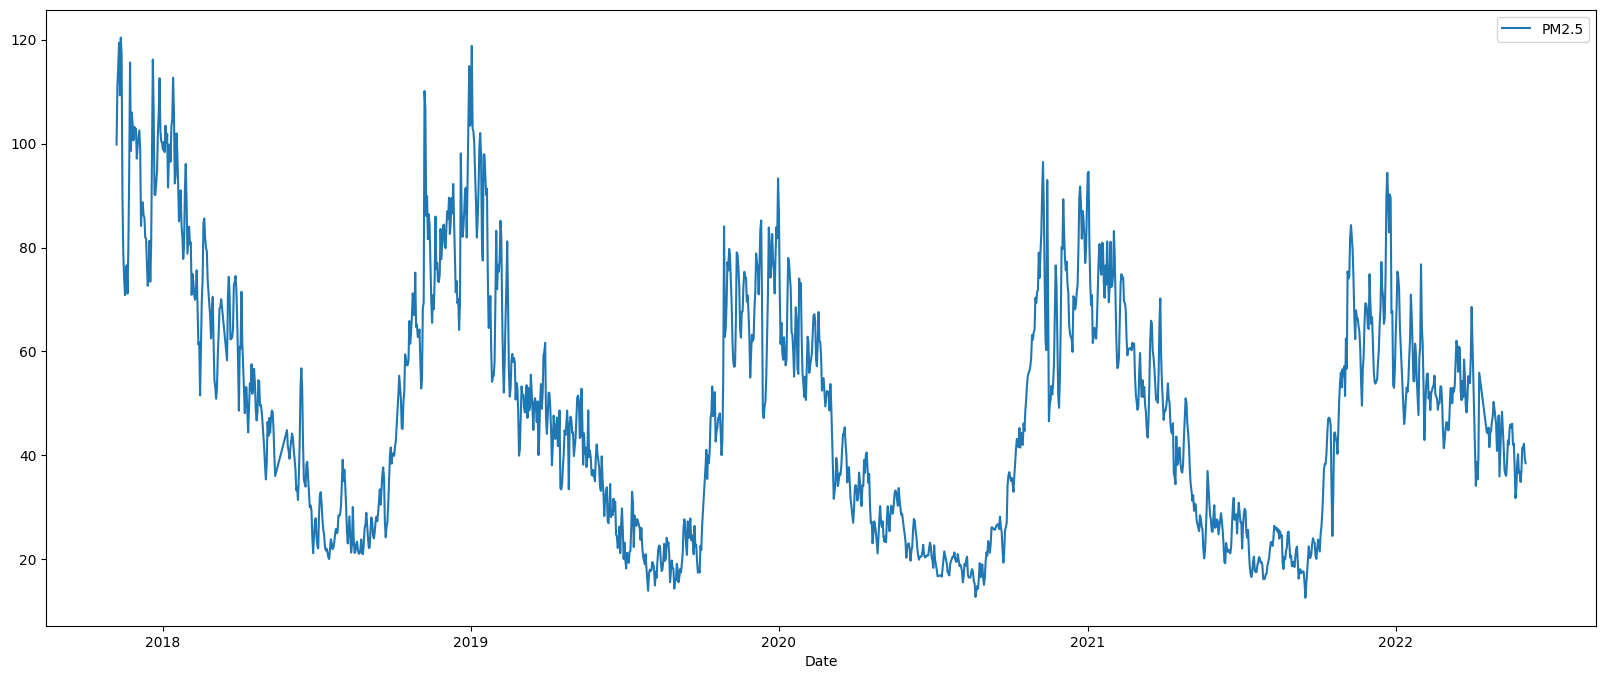

In [19]:
df_date.plot(figsize=(20, 8))

print("Total samples: " + str(len(df_date.index)))


### Imposto la lunghezza del train set

In [5]:
dataset = df_date.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len


1293

### Eseguo lo scaling dei dati

In [6]:
sc = MinMaxScaler(feature_range=(0, 1))
scaled_data = sc.fit_transform(dataset)
scaled_data


array([[0.80924161],
       [0.91297267],
       [0.94951492],
       ...,
       [0.27497376],
       [0.24870153],
       [0.24014526]])

### Split del Dataset e preparazione dei dati

In [7]:
time_steps = 5

train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i , 0])
    y_train.append(train_data[i , 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
print("Train: " + str(x_train.shape))

test_data = scaled_data[training_data_len-time_steps: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print("Test: " + str(x_test.shape))


Train: (1288, 5, 1)
Test: (323, 5, 1)


### Creazione del modello

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(20, input_shape=(x_train.shape[1], 1)))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer = "adam", loss = "mean_squared_error")

#batch_size = 1
batch_size = 4
epochs = 10
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)


Epoch 1/10
322/322 [==============================] - 5s 4ms/step - loss: 0.0091
Epoch 2/10
322/322 [==============================] - 2s 5ms/step - loss: 0.0046
Epoch 3/10
322/322 [==============================] - 2s 7ms/step - loss: 0.0044
Epoch 4/10
322/322 [==============================] - 1s 4ms/step - loss: 0.0041
Epoch 5/10
322/322 [==============================] - 2s 5ms/step - loss: 0.0039
Epoch 6/10
322/322 [==============================] - 2s 6ms/step - loss: 0.0036
Epoch 7/10
322/322 [==============================] - 1s 4ms/step - loss: 0.0034
Epoch 8/10
322/322 [==============================] - 2s 6ms/step - loss: 0.0032
Epoch 9/10
322/322 [==============================] - 1s 4ms/step - loss: 0.0030
Epoch 10/10
322/322 [==============================] - 2s 5ms/step - loss: 0.0028


### Accuratezza del modello

In [9]:
# testo il modello
y_pred = sc.inverse_transform(model.predict(x_test))

def mean_absolute_percentage_error(y_true, y_pred):
    actual, pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

print("MAE: " + str(metrics.mean_absolute_error(y_test, y_pred)))
print("MSE: " + str(metrics.mean_squared_error(y_test, y_pred)))
print("MAPE: " + str(mean_absolute_percentage_error(y_test, y_pred)))


11/11 [==============================] - 1s 3ms/step
MAE: 3.4383087449790137
MSE: 26.02926913764591
MAPE: 8.344737421251176


### Previsione sui dati del test set

In [10]:
# tutti i valori del test
predictions = sc.inverse_transform(model.predict(x_test))

train = df_date[:training_data_len]
valid = df_date[training_data_len:]
valid["Predictions"] = predictions
print(valid.head())


11/11 [==============================] - 0s 3ms/step
                PM2.5  Predictions
Date                              
2021-06-28  28.667917    27.541468
2021-06-29  30.903750    28.872168
2021-06-30  29.017917    30.699888
2021-07-01  27.166667    30.306015
2021-07-02  27.132917    29.100420


### Visualizzazione delle previsioni sul test set

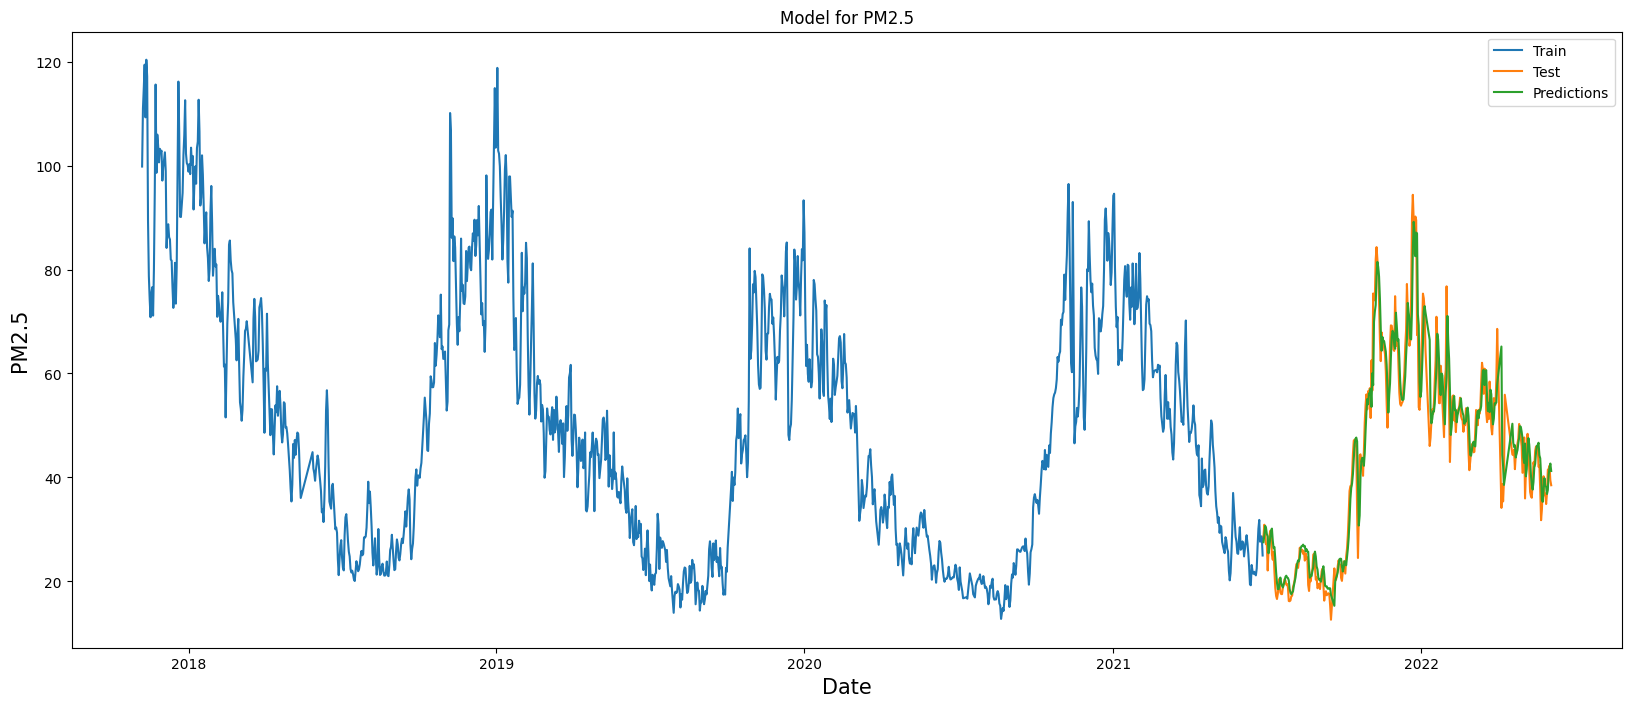

In [11]:
plt.figure(figsize=(20, 8))
plt.title("Model for PM2.5")
plt.xlabel("Date", fontsize = 15)
plt.ylabel("PM2.5", fontsize=15)
plt.plot(train[df_date.columns])
plt.plot(valid["PM2.5"])
plt.plot(valid["Predictions"])
plt.legend(["Train", "Test", "Predictions"])


### Seleziono un sample dal Dataset di test da salvare nel file header

In [12]:
cpp_dataset_variables = ""

# seleziono il primo sample del test set
first_sample_x = x_test[0]
first_sample_y = y_test[0:1]

cpp_dataset_variables = "float x_test[5] = "
x_values_str = str([ x[0] for x in first_sample_x ])
x_values_str = x_values_str.replace("[", "{ ")
x_values_str = x_values_str.replace("]", " };\n")

cpp_dataset_variables += x_values_str

# trasformo l'output per fare in modo che sia coerente con quello sul microcontrollore
cpp_dataset_variables += "const float y_test = " + str(sc.transform(first_sample_y)[0][0]) + ";"

print(cpp_dataset_variables)

float x_test[5] = { 0.17820177822943262, 0.13932285450054016, 0.1448233133694416, 0.14903409734511341, 0.11468296491200151 };
const float y_test = 0.1488345481423325;


### Salvo il modello nel file header

In [13]:
# fisso la dimensione degli input
BATCH_SIZE = batch_size
STEPS = time_steps
INPUT_SIZE = 1
concrete_func = tf.function(lambda x: model(x)).get_concrete_function(
                tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype)
)

# salvo modello (.tflite)
MODEL_DIR = "assets/tf_models"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

# converto modello in tf-lite 
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)

converter.optimizations = []
converter.allow_custom_ops = False
converter.experimental_new_converter = True

tflite_model = converter.convert()


# converto modello in file header
preamble = '''
// if having troubles with min/max, uncomment the following
// #undef min    
// #undef max
#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif
'''

variable_name = "AirQualityModel"

# uso il modello (.tflite) salvato precedentemente
bytes = hexdump.dump(tflite_model).split(' ')
model_array = ", ".join(["0x%02x" % int(byte, 16) for byte in bytes])
body = "const unsigned char %s[] DATA_ALIGN_ATTRIBUTE = {%s};" % (variable_name, model_array)
body += "\nconst int %s_len = %d;" % (variable_name, len(bytes))

cpp_code = preamble + body

cpp_code += "\n"
cpp_code = cpp_code + cpp_dataset_variables


# cpp_files
with open("assets/cpp_files/AirQuality.h", "w+") as f:
    f.write(cpp_code)

# esp32
with open("../AirQuality/AQ_ESP32/include/AirQuality.h", "w+") as f:
    f.write(cpp_code)

# esp8266
with open("../AirQuality/AQ_ESP8266/include/AirQuality.h", "w+") as f:
    f.write(cpp_code)

# wemos
with open("../AirQuality/AQ_WEMOS/include/AirQuality.h", "w+") as f:
    f.write(cpp_code)


INFO:tensorflow:Assets written to: assets/tf_models/assets


INFO:tensorflow:Assets written to: assets/tf_models/assets


### Aggiornare la versione delle librerie sui microcontrollori (esp32 e esp8266)

cd .pio/libdeps/esp32dev/TensorFlowLite_ESP32/scripts/

chmod +x ./sync_from_tflite_micro.sh

./sync_from_tflite_micro.sh

Sistemare tutti i file che non trova.

### Previsione di un singolo sample

In [14]:
# primo elemento del test
# Non è stata eseguita la transformazione inversa dell'output per avere un confronto con il risultato 

output = model.predict(x_test[0:1])

print(x_test[0:1])

# Trasformazione della y reale 
y_hat = sc.transform(y_test[0:1])

# Output del modello e valore reale (trasformato).
print("PM2.5 : " + str(y_hat))
print("Prediction : " + str(output))

1/1 [==============================] - 0s 37ms/step
[[[0.17820178]
  [0.13932285]
  [0.14482331]
  [0.1490341 ]
  [0.11468296]]]
PM2.5 : [[0.14883455]]
Prediction : [[0.13837719]]
